In [143]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [144]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from mstream.mstream import Mstream

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

In [146]:
DS_DIR = "data"
DS_NAMES = ["News", "News-T", "Tweets", "Tweets-T"]
DS_NAMES = ["Tweets"]
DS_PATHS = [os.path.join(DS_DIR, ds_name) for ds_name in DS_NAMES]

<IPython.core.display.Javascript object>

In [18]:
def load_batches(ds_path, batch_size=int(2 ** 8)):
    with open(ds_path) as f:
        docs = []
        for line in f:
            parsed_line = json.loads(line)
            docs.append(parsed_line)
            if len(docs) == batch_size:
                yield docs
                docs = []
        if len(docs) > 0:
            yield docs

<IPython.core.display.Javascript object>

In [25]:
def transform(docs):
    return [{"id": doc["Id"], "word_list": doc["textCleaned"].split()} for doc in docs]

<IPython.core.display.Javascript object>

In [5]:
def calc_nmi(y, y_hat):
    return normalized_mutual_info_score(y, y_hat)

<IPython.core.display.Javascript object>

In [46]:
num_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_docs / 8)
mstream = Mstream()
parsed_docs = next(load_batches(DS_PATHS[2], batch_size))
docs = transform(parsed_docs)
res = mstream.process(docs)
res

[32,
 39,
 80,
 38,
 30,
 71,
 67,
 16,
 74,
 11,
 91,
 7,
 39,
 46,
 59,
 67,
 90,
 78,
 49,
 9,
 86,
 41,
 79,
 78,
 11,
 44,
 11,
 59,
 85,
 81,
 87,
 68,
 37,
 18,
 28,
 33,
 11,
 28,
 52,
 53,
 41,
 17,
 88,
 31,
 86,
 38,
 56,
 5,
 63,
 47,
 91,
 82,
 32,
 65,
 56,
 17,
 58,
 48,
 26,
 68,
 14,
 13,
 78,
 76,
 21,
 33,
 38,
 43,
 22,
 33,
 82,
 17,
 89,
 53,
 77,
 45,
 90,
 24,
 91,
 54,
 71,
 20,
 12,
 6,
 63,
 48,
 80,
 37,
 52,
 48,
 10,
 51,
 9,
 41,
 28,
 11,
 26,
 47,
 84,
 65,
 41,
 83,
 64,
 10,
 92,
 10,
 77,
 66,
 87,
 27,
 68,
 52,
 79,
 45,
 69,
 16,
 39,
 50,
 69,
 39,
 42,
 14,
 12,
 22,
 63,
 20,
 38,
 18,
 6,
 35,
 11,
 34,
 25,
 27,
 85,
 36,
 64,
 43,
 56,
 87,
 65,
 84,
 21,
 33,
 47,
 63,
 5,
 62,
 82,
 9,
 42,
 8,
 59,
 29,
 2,
 36,
 78,
 75,
 18,
 76,
 85,
 31,
 49,
 20,
 51,
 19,
 79,
 49,
 40,
 71,
 63,
 23,
 52,
 89,
 89,
 59,
 71,
 60,
 83,
 74,
 67,
 4,
 89,
 63,
 84,
 58,
 61,
 29,
 46,
 12,
 41,
 83,
 11,
 18,
 51,
 37,
 41,
 69,
 33,
 43,
 92,
 41,
 

<IPython.core.display.Javascript object>

Caculate the NMI for each batch

In [67]:
num_batches = 16
num_total_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_total_docs / num_batches)
mstream = Mstream()
nmis = []
for parsed_docs in load_batches(DS_PATHS[2], batch_size):
    docs = transform(parsed_docs)
    nmi = normalized_mutual_info_score(
        [doc["clusterNo"] for doc in parsed_docs], mstream.process(docs)
    )
    nmis.append(nmi)

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (16,) and (10,)

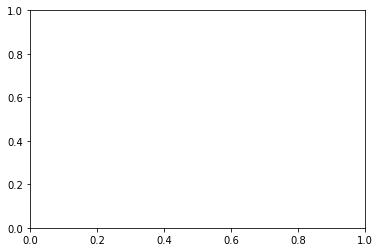

<IPython.core.display.Javascript object>

In [72]:
plt.plot(range(1, num_batches + 1), nmis)
plt.ylabel("NMI")
plt.xlabel("Batch number")
plt.title("NMI for each batch")
plt.show()

Calculate the NMI as a function of the number of iterations

In [151]:
num_batches = 16
max_num_iter = 3
num_iters = list(range(1, max_num_iter))
ds_nmis = []
for ds_path in DS_PATHS:
    num_total_docs = sum([len(batch) for batch in load_batches(ds_path)])
    batch_size = math.ceil(num_total_docs / num_batches)
    nmis = []
    for num_iter in num_iters:
        mstream = Mstream(num_iter)
        y_hat = []
        y = []
        for parsed_docs in load_batches(ds_path, batch_size):
            y += [doc["clusterNo"] for doc in parsed_docs]
            y_hat += mstream.process(transform(parsed_docs))
        nmi = normalized_mutual_info_score(y, y_hat)
        nmis.append(nmi)
    ds_nmis.append(nmis)

<IPython.core.display.Javascript object>

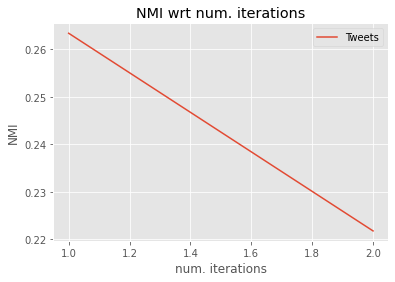

<IPython.core.display.Javascript object>

In [152]:
ncols = 2
nrows = math.ceil(len(ds_nmis) / ncols)
fig, ax = plt.subplots()
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()

ValueError: x and y must have same first dimension, but have shapes (10,) and (16,)

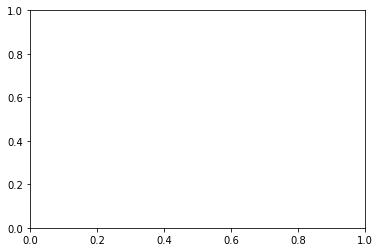

<IPython.core.display.Javascript object>

In [65]:
plt.plot(num_iters, nmis)
plt.ylabel("NMI")
plt.xlabel("Num. iterations")
plt.title("NMI wrt number of iterations")
plt.show()